<a href="https://colab.research.google.com/github/vitorgaboardi/network_analysis/blob/main/Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Introduction



In this lesson, we use Twitter data to create and explore directed networks of social interactions. For this lesson, we'll be using a developer workflow where we assume you have access to an app's API key and secret (see the slides).


Contents:

1. Introduction
2. Authenticating with Twitter's API
3. Using Twitter's search API to get tweets of interest
4. Creating social network graphs

***Copyright:*** *Parts of the contents of this Colab Notebook, unless otherwise indicated, are Copyright 2020 Filippo Menczer, Santo Fortunato and Clayton A. Davis, [A First Course in Network Science](https://github.com/CambridgeUniversityPress/FirstCourseNetworkScience). All rights reserved.* 

***References***: getting started with the Twitter API v2 for academic research [here](https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research). 


# 2.0 Authenticating with Twitter's API



Twitter uses OAuth in order to allow third-party apps to access data on your behalf without requiring your Twitter login credentials -- note that none of the code in this notebook asks for your Twitter screen name or password.

The OAuth "dance" can be intimidating when you first use it, but it provides a far more secure way for software to make requests on your behalf than providing your username and password.

We'll make use of the
[Twython](https://twython.readthedocs.io/en/latest/usage/starting_out.html#authentication)
package to help us with authentication and querying Twitter's APIs.

In [1]:
!pip install Twython

In [2]:
from twython import Twython, TwythonError
import pandas as pd


## 2.1 Enter app info and get auth URL



In order to authenticate with Twitter, we'll provide the app details and  ask for a one-time authorization URL to authenticate your user with this app.

Copy and paste the API key and secret from your Twitter app into a file named <font color="red">keys.txt</font>. The first line is the API_KEY and the second line of the file is API_SECRET_KEY. For example, a template for the <font color="red">keys.txt</font>: 

```python
df6cf09894907b92f3ea749ef
d19c40cbb184f72055c806f107b5158d023a43eb7d8921a0d0
```

In [ ]:
# open the keys file
my_file = open("keys.txt", "r")

# read the raw data
content = my_file.read()

# split all lines by  newline character
API_KEY, API_SECRET_KEY = content.split("\n")

# close the file
my_file.close()

Executing the cell should then print out a clickable URL. This link is unique and will work **exactly** once. <font color="red"> Visit this URL, log into Twitter, and then copy the verifier pin that is given to you so as to paste it in the next step</font>.

In [ ]:
twitter = Twython(API_KEY, API_SECRET_KEY)

authentication_tokens = twitter.get_authentication_tokens()
print(authentication_tokens['auth_url'])

https://api.twitter.com/oauth/authenticate?oauth_token=7DhRdAAAAAABTfzIAAABe8Y_kA0


## 2.2 Authorize app using verifier PIN



That verifier PIN goes into the next cell. This will be different every time you run these steps. The `authentication_tokens` include temporary tokens that go with this verifier PIN; by submitting these together, we show Twitter that we are who we say we are.

In [ ]:
# Replace the verifier with the pin number obtained with your web browser in the previous step
VERIFIER = '5417584'

twitter = Twython(API_KEY, API_SECRET_KEY,
                  authentication_tokens['oauth_token'],
                  authentication_tokens['oauth_token_secret'])

authorized_tokens = twitter.get_authorized_tokens(VERIFIER)


## 2.3 Use authorized tokens



Now we have a permanent token pair that we can use to make authenticated calls to the Twitter API. We'll create a new Twython object using these authenticated keys and verify the credentials of the logged-in user.

In [ ]:
twitter = Twython(API_KEY, API_SECRET_KEY,
                  authorized_tokens['oauth_token'],
                  authorized_tokens['oauth_token_secret'])

twitter.verify_credentials()

If the previous cell ran without error and printed out a dict corresponding to a
[Twitter User](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object),
then you're good. The authorized token pair is like a username/password and should be protected as such.


# 3.0 Using Twitter's search API to get tweets of interest



Twitter's
[Search API](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html)
allows you to fetch recent tweets according to a query of keywords, URLs, hashtags, user mentions, etc.


According to the [Twitter Documentation](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets), the standard student account can have 180 requests considering a 15-min window, where it is possible to get 100 tweets at each request. Thus, we can get up to 18k tweets in a 15-min window (180 x 100 = 18000). If you want to get more than 18k tweets, it is necessary to use a function that waits for another 15 minutes before trying to get another set of 18k tweets.

In this notebook, we will build a dataset with 72k tweets, so we will spent 15*4 = 60 minutes to create it. To force the algorithm to wait for 15 minutes, we will use the sleep function.


In this particular application, we want to analyse the most influence politician or public figure considering the tweets performed on the Brazilian Independence Day (which is in September 7th). To build our network, we will use information considering tweets that have the words **#7DeSetembro** and **Independência**, since both were used many times in the day for different political parties.

Thus, the first 36k tweets will be searched considering the word **#7DeSetembro** and the final 36k tweets will be searched considering the word **Independência**. 

To build our database, we will get the following information from the a tweet:
* user: Name of the user that made the tweet.
* tweet_date: Time that this Tweet was created.
* text: The actual UTF-8 text of the status update.
* favorite_count: Indicates approximately how many times the Tweet has been liked by Twitter users.
* user_tweets_count: The number of Tweets (including retweets) issued by the user.
* user_creation: datetime that the user account was created on Twitter.
* location:  The user-defined location for this account’s profile.
* retweeted: Whether the Tweet is a Retweet.
* retweeted_from: User that originally created the Tweet (only if it is a Retweet)
* retweet_count: Number of times that the Tweet was Retweeted.

In [ ]:
import pandas as pd
import time

# Search tweets
words = ['#7DeSetembro', 'Independência']
types = ['recent','popular']

dict_ = {'user': [], 'tweet_date': [], 'text': [], 'favorite_count': [], 'user_tweets_count': [], 'user_creation': [], 'location': [], 'retweeted': [], 'retweeted_from': [], 'retweet_count': []}

# Uses the maximum amount of tweets 4 times
for i in range(4):
  word = words[0] if i < 2 else words[1]          # First 2 iterations will be the first word (#7DeSetembro) and last 2 iterations will be second word ('Independência')
  
  # Go over the maximum number of requests in a 15-min window
  for j in range(180):
    result_type = types[1] if j==0 and i%2==0 else types[0]    # Last iteration of each word will consider 100 most popular tweets
    max_id = 0 if j<=1 and i%2==0 else max_id                  # Restart the id

    # Get tweets:
    get_tweets = twitter.search(q=word, count=100, result_type=result_type,until='2021-09-08',max_id = max_id-1)

    for tweet in get_tweets['statuses']:
      dict_['user'].append(tweet['user']['screen_name'])
      dict_['tweet_date'].append(tweet['created_at'])
      dict_['text'].append(tweet['text'])
      dict_['favorite_count'].append(tweet['favorite_count'])
      dict_['retweet_count'].append(tweet['retweet_count'])
      dict_['user_tweets_count'].append(tweet['user']['statuses_count'])
      dict_['user_creation'].append(tweet['user']['created_at'])
      dict_['location'].append(tweet['user']['location'])
    
      # check whether this tweet is a retweet or not
      if 'retweeted_status' in tweet:
        dict_['retweeted'].append(True)
        dict_['retweeted_from'].append(tweet['retweeted_status']['user']['screen_name'])
      else:
        dict_['retweeted'].append(False)
        dict_['retweeted_from'].append('')

    #print(i, j, word, result_type)
    max_id = get_tweets['statuses'][-1]['id']

  # waits the time for getting the next number of requisitions.
  twitter.get_application_rate_limit_status()['resources']['search']
  print(i, j, word, result_type)
  
  if(i < 3):
    time.sleep(905)

# Structure data in a pandas DataFrame for easier manipulation
df = pd.DataFrame(dict_)

0 179 #7DeSetembro recent
1 179 #7DeSetembro recent
2 179 Independência recent
3 179 Independência recent


In [ ]:
df.head(5)

,user,tweet_date,text,favorite_count,user_tweets_count,user_creation,location,retweeted,retweeted_from,retweet_count
0,BrasiliaUAE,Tue Sep 07 15:04:00 +0000 2021,A Embaixada dos #EAU em Brasília deseja prospe...,11290,1696,Sun Sep 20 20:28:53 +0000 2015,"Brasília, DF - Brasil",False,,2251
1,MarinaSilva,Tue Sep 07 14:32:30 +0000 2021,#7desetembro #forabolsonaro https://t.co/bVr1q...,16793,13653,Fri Jan 15 14:33:57 +0000 2010,Brasil,False,,2513
2,randolfeap,Tue Sep 07 13:47:36 +0000 2021,"Superaremos esse tempo, página infeliz da noss...",4953,28766,Mon Oct 26 14:29:38 +0000 2009,"Amapá, Brasil",False,,508
3,randolfeap,Tue Sep 07 21:13:45 +0000 2021,"- Gasolina a R$ 7,00\n\n- Kg da carne R$ 50,00...",5125,28766,Mon Oct 26 14:29:38 +0000 2009,"Amapá, Brasil",False,,559
4,exercitooficial,Tue Sep 07 10:24:54 +0000 2021,7 de Setembro - #DiadaIndependência do Brasil....,4830,26559,Mon Aug 30 12:31:22 +0000 2010,Brasil,False,,1102


The cell below saves the created DataFrame.

In [ ]:
df.to_csv("datafra.csv")

Finally, the cell below shows the amount of requests that you can still perform within the 15-min window.

In [ ]:
# current limits to followers/list endpoint
twitter.get_application_rate_limit_status()['resources']["search"]

{'/search/tweets': {'limit': 180, 'remaining': 180, 'reset': 1631144706}}

# 4.0 Twitter retweet network



One fundamental interaction in the Twitter ecosystem is the "retweet" -- rebroadcasting another user's tweet to your followers. A tweet object returned by the API is a retweet if it includes a `'retweeted_status'`. We're going to fetch tweets matching a hashtag and create a retweet network of the conversation.


If it is necessary to reload the database, run the cell below.

In [4]:
df = pd.read_csv('datafra.csv', index_col=0)

In [5]:
df.head()

,user,tweet_date,text,favorite_count,user_tweets_count,user_creation,location,retweeted,retweeted_from,retweet_count
0,BrasiliaUAE,Tue Sep 07 15:04:00 +0000 2021,A Embaixada dos #EAU em Brasília deseja prospe...,11290,1696,Sun Sep 20 20:28:53 +0000 2015,"Brasília, DF - Brasil",False,NaN,2251
1,MarinaSilva,Tue Sep 07 14:32:30 +0000 2021,#7desetembro #forabolsonaro https://t.co/bVr1q...,16793,13653,Fri Jan 15 14:33:57 +0000 2010,Brasil,False,NaN,2513
2,randolfeap,Tue Sep 07 13:47:36 +0000 2021,"Superaremos esse tempo, página infeliz da noss...",4953,28766,Mon Oct 26 14:29:38 +0000 2009,"Amapá, Brasil",False,NaN,508
3,randolfeap,Tue Sep 07 21:13:45 +0000 2021,"- Gasolina a R$ 7,00\n\n- Kg da carne R$ 50,00...",5125,28766,Mon Oct 26 14:29:38 +0000 2009,"Amapá, Brasil",False,NaN,559
4,exercitooficial,Tue Sep 07 10:24:54 +0000 2021,7 de Setembro - #DiadaIndependência do Brasil....,4830,26559,Mon Aug 30 12:31:22 +0000 2010,Brasil,False,NaN,1102


First, we will make a copy of the DataFrame, to make sure all the previous modifications are saved.

In [6]:
df_retweet = df.copy()

Now, we will filter only the samples where the *retweeted* column is **True**. Also, it is possible that duplicates occurred, so we will drop them.

In [7]:
df_retweet = df_retweet[df_retweet['retweeted'] == True].drop_duplicates()


Each tweet in this list of *df_retweet* represents an edge in our network. <font color='red'>We're going to draw these edges in the direction of information flow</font>: from the retweeted user to the retweeter, the user doing the retweeting. Since a user can retweet another user more than once, we want this graph to be weighted, with the number of retweets as the weight.

In [8]:
df_retweet.head()

,user,tweet_date,text,favorite_count,user_tweets_count,user_creation,location,retweeted,retweeted_from,retweet_count
15,sheilal43605454,Tue Sep 07 23:59:58 +0000 2021,RT @realpfigueiredo: O jornalismo profissional...,0,83518,Thu Jan 23 20:06:40 +0000 2020,NaN,True,realpfigueiredo,3118
16,GuerreiroDirei1,Tue Sep 07 23:59:57 +0000 2021,RT @SigaGazetaBR: 🤳VC no #7deSetembro- Copacab...,0,8510,Mon Jun 01 00:26:01 +0000 2020,NaN,True,SigaGazetaBR,179
17,carneiraczs,Tue Sep 07 23:59:57 +0000 2021,RT @falemateus: Sempre bom lembrar. #7DeSetemb...,0,3794,Mon Dec 10 06:42:17 +0000 2018,NaN,True,falemateus,1126
18,CS20seven,Tue Sep 07 23:59:56 +0000 2021,RT @realpfigueiredo: O jornalismo profissional...,0,7140,Sat May 02 22:35:43 +0000 2020,NaN,True,realpfigueiredo,3118
19,Mozelli1,Tue Sep 07 23:59:55 +0000 2021,RT @cardoso_boni: No dia 07 de Setembro o PR. ...,0,45417,Sat Jan 02 19:30:22 +0000 2016,RJ,True,cardoso_boni,901


In [19]:
import networkx as nx
from datetime import date

month_name_to_number = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
year_user_creation = [[], [], []]

D = nx.DiGraph()

for index, row in df_retweet.iterrows():
    retweeted_sn = row['retweeted_from']
    retweeter_sn = row['user'] 

    # Adding an atribute to see if it was retweeted from Lula, Bolsonaro, or else
    if retweeted_sn == 'LulaOficial':
      if retweeter_sn not in D:
        year_user_creation[0].append(year)
    elif retweeted_sn == 'jairbolsonaro':
      if retweeter_sn not in D:
        year_user_creation[1].append(year)
    else:
      if retweeter_sn not in D:
        year_user_creation[2].append(year)
    
    # Edge direction: retweeted_sn -> retweeter_sn
    if D.has_edge(retweeted_sn, retweeter_sn):
        D.edges[retweeted_sn, retweeter_sn]['weight'] += 1
    else:
        D.add_edge(retweeted_sn, retweeter_sn, weight=1)

    # Computing days  
    user_date_creation = row['user_creation'].split(" ")
    day = int(user_date_creation[2])
    month = month_name_to_number[user_date_creation[1]]
    year = int(user_date_creation[-1])  

    days_user_creation = (date(2021,9,7)-date(year,month,day)).days + 1

    # Adding the year that the retweeter_sn created Twitter
    #if retweeter_sn not in D:
    #  year_user_creation.append(year)

    # Creating attributes related to the amount of tweets made
    nx.set_node_attributes(D, {retweeter_sn: days_user_creation}, name="days_user_creation")
    nx.set_node_attributes(D, {retweeter_sn: row['user_tweets_count']/days_user_creation}, name="posts/days_user_creation")
    nx.set_node_attributes(D, {retweeter_sn: row['user_tweets_count']}, name="posts")

    # Adding an atribute to see if it was retweeted from Lula, Bolsonaro, or else
    if retweeted_sn == 'LulaOficial':
      nx.set_node_attributes(D, {retweeter_sn: "lula"}, name="party")
    elif retweeted_sn == 'jairbolsonaro':
      nx.set_node_attributes(D, {retweeter_sn: "bolsonaro"}, name="party")
    else:
      nx.set_node_attributes(D, {retweeter_sn: "none"}, name="party")


Saving the created Graph using Network X.

In [ ]:
nx.write_graphml(D, "september7.graphml")

Showing information related to a Twitter user.

In [10]:
list(D.in_edges('Claudinha511',data=True))

[('AnaPaulaVolei', 'Claudinha511', {'weight': 1}),
 ('DefesaGovBr', 'Claudinha511', {'weight': 3}),
 ('realpfigueiredo', 'Claudinha511', {'weight': 3}),
 ('MarceloRochaMon', 'Claudinha511', {'weight': 1}),
 ('SigaGazetaBR', 'Claudinha511', {'weight': 15}),
 ('CmdoCMP', 'Claudinha511', {'weight': 1}),
 ('LucianoHangBr', 'Claudinha511', {'weight': 1}),
 ('allanldsantos', 'Claudinha511', {'weight': 1}),
 ('zoemartinez_05', 'Claudinha511', {'weight': 1}),
 ('bernardokuster2', 'Claudinha511', {'weight': 1}),
 ('JornalBSM', 'Claudinha511', {'weight': 1}),
 ('mqueiroga2', 'Claudinha511', {'weight': 1})]

)The edge addition logic here is to increase the edge weight by 1 if the edge exists, or else create the edge with weight 1 if it does not exist.

When writing code such as this that refers multiple times to the same directed edge, make sure to be consistent with the edge direction.

## 6.1 Analyze graph



Now that we have this graph, let's ask some questions about it.



### 6.1.1 Most retweeted user



Since the edges are in the direction of information flow, out-degree gives us the number of other users retweeting a given user. We can get the user with highest out-degree using the built-in `max` function:

In [11]:
max(D.nodes, key=D.out_degree)

'realpfigueiredo'

but we can get more context and information from the "top N" users:

In [12]:
from operator import itemgetter

sorted(D.out_degree(), key=itemgetter(1), reverse=True)[:20]

[('realpfigueiredo', 4110),
 ('LulaOficial', 3265),
 ('aramagem', 2799),
 ('SigaGazetaBR', 1941),
 ('ErikakHilton', 1867),
 ('WRosarioCGU', 1729),
 ('jairbolsonaro', 1710),
 ('BrasiliaUAE', 1596),
 ('MarinaSilva', 1546),
 ('brwninh4', 1300),
 ('eixopolitico', 1298),
 ('zoemartinez_05', 934),
 ('jdoriajr', 857),
 ('GilDoVigor', 760),
 ('AnaPaulaVolei', 690),
 ('falemateus', 682),
 ('MiguelDiazOK1', 611),
 ('randolfeap', 540),
 ('alexandre', 518),
 ('depheliolopes', 492)]

In this piece of code, we take advantage of the fact that `D.out_degree()` returns a sequence of `(name, degree)` 2-tuples; specifying `key=itemgetter(1)` tells the `sorted` function to sort these 2-tuples by their value at index 1. Giving `reverse=True` tells the `sorted` function that we want this in descending order, and the `[:5]` at the end slices the first 5 items from the resulting list.

However, this is a weighted graph! By default, `out_degree()` ignores the edge weights. We can get out-strength by telling the `out_degree()` function to take into account the edge weight:

In [13]:
sorted(D.out_degree(weight='weight'), key=itemgetter(1), reverse=True)[:20]

[('realpfigueiredo', 5039),
 ('LulaOficial', 3300),
 ('SigaGazetaBR', 3048),
 ('aramagem', 2800),
 ('ErikakHilton', 2247),
 ('jairbolsonaro', 1737),
 ('WRosarioCGU', 1729),
 ('MarinaSilva', 1609),
 ('BrasiliaUAE', 1596),
 ('eixopolitico', 1340),
 ('brwninh4', 1300),
 ('zoemartinez_05', 934),
 ('jdoriajr', 869),
 ('GilDoVigor', 760),
 ('AnaPaulaVolei', 690),
 ('falemateus', 682),
 ('DefesaGovBr', 643),
 ('MiguelDiazOK1', 611),
 ('randolfeap', 553),
 ('alexandre', 518)]

In some cases these two results will be the same, namely if none of these users has been retweeted multiple times by the same user. Depending on your use case, you may or may not wish to take the weights into account.


*texto em itálico*
### 6.4.2 Anomaly detection



One type of social media manipulation involves accounts that create very little original content, instead "spamming" retweets of any and all content in a particular conversation. Can we detect any users doing significantly more retweeting than others? Let's look at the top N retweeters:

In [14]:
sorted(D.in_degree(weight='weight'), key=itemgetter(1), reverse=True)[:20]

[('Claudinha511', 30),
 ('dudu_santana05', 30),
 ('brunoal02852156', 27),
 ('AleDireita', 25),
 ('macmachado57', 25),
 ('OnCorretor', 25),
 ('Rafinha30378349', 23),
 ('jldiniz1', 22),
 ('leotizzo', 21),
 ('Ihamma_1', 21),
 ('thomasalgarvio', 21),
 ('GleisonGilton', 21),
 ('eu_juuuuh', 21),
 ('helenoofreire', 20),
 ('LuizOficialFe25', 20),
 ('PedroLi41542560', 20),
 ('MagooMito', 20),
 ('Patriota38Paulo', 19),
 ('deivid_lembeck', 19),
 ('EDERSON70039945', 19)]

### 6.4.3 Bot detection

In [15]:
sorted(D.nodes(data='posts/days_user_creation'), key = lambda x: (x[1] is not None, x[1]), reverse=True)[:20]

[('BrisaBot', 2206.7221206581353),
 ('uai_bot', 2109.4151515151516),
 ('TheDeveloperBot', 1762.173828125),
 ('CaraioBot', 1704.3630434782608),
 ('CarlaoBot', 1442.1832298136646),
 ('sarah052794', 1412.7054582904223),
 ('internacionalzp', 1314.4418604651162),
 ('macaquinho_bot', 1234.3992606284658),
 ('corinthianszip', 1195.7777777777778),
 ('vascozip', 1078.5229357798164),
 ('JampaRobo', 931.2257462686567),
 ('odio_nao', 898.3236034222446),
 ('Kyle89156297', 892.9512195121952),
 ('wagnerbonoro', 862.0),
 ('dogandwinelover', 832.9779944986246),
 ('Srgio45860350', 821.5),
 ('IndieAoba', 784.7627118644068),
 ('atleticozip', 765.3604651162791),
 ('Leonor59421694', 763.7705882352941),
 ('Lucas07071983', 763.0)]

# 6.4.3 Data Creation

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


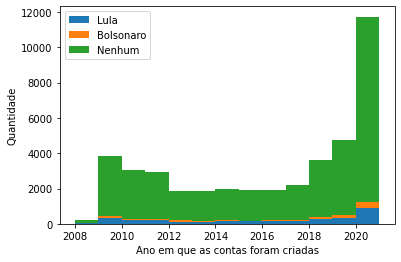

In [31]:
import numpy as np
import matplotlib.pyplot as plt

bins = [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]

plt.hist(year_user_creation, stacked=True,bins=bins)
plt.legend(["Lula", "Bolsonaro", "Nenhum"],loc='upper left')
plt.ylabel("Quantidade")
plt.xlabel("Ano em que as contas foram criadas")
plt.show()